## Setup

In [ ]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
import glob
import seaborn as sns

import torchvision

import torch.optim as optim

from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/CS464HW3Data/archive.zip > /dev/null

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


In [ ]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
      super(Dataset, self).__init__()
      self.data = torch.from_numpy(data)
      self.label = torch.from_numpy(labels)
      self.count = data.shape[0]

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        return (self.label[index], self.data[index])

In [ ]:
def get_dataset():
    # Initializing empty lists
    pixel_list = []
    label_list = []
    
    i=0
    root_dir = '/content/Multi-class Weather Dataset/Cloudy'
    # Traversing through data
    for path in os.listdir(root_dir):
      im = Image.open(root_dir+'/'+path).convert('RGB').resize((224,224),Image.BILINEAR)
      data = im.getdata()
      pixel_list.append(data)
      label_list.append(i)

    i = 1
    root_dir = '/content/Multi-class Weather Dataset/Rain'
    # Traversing through data
    for path in os.listdir(root_dir):
      im = Image.open(root_dir+'/'+path).convert('RGB').resize((224,224),Image.BILINEAR)
      data = im.getdata()
      pixel_list.append(data)
      label_list.append(i)

    i = 2
    root_dir = '/content/Multi-class Weather Dataset/Shine'
    # Traversing through data
    for path in os.listdir(root_dir):
      im = Image.open(root_dir+'/'+path).convert('RGB').resize((224,224),Image.BILINEAR)
      data = im.getdata()
      pixel_list.append(data)
      label_list.append(i)

    i = 3
    root_dir = '/content/Multi-class Weather Dataset/Sunrise'
    # Traversing through data
    for path in os.listdir(root_dir):
      im = Image.open(root_dir+'/'+path).convert('RGB').resize((224,224),Image.BILINEAR)
      data = im.getdata()
      pixel_list.append(data)
      label_list.append(i)

    pixel_array = np.asarray(pixel_list)
    pixel_array = pixel_array.reshape(1125,224,224,3)
    pixel_array = np.swapaxes(pixel_array,1,2)
    pixel_array = np.swapaxes(pixel_array,1,3)
    pixel_array_n = (pixel_array - np.amin(pixel_array))/(np.amax(pixel_array) - np.amin(pixel_array))
    label_array = np.asarray(label_list)
    train, x_test, label, y_test = train_test_split(pixel_array_n, label_array, test_size = 0.2)
    x_train, x_val, y_train, y_val = train_test_split(train, label, test_size = 0.125)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [ ]:
train_dataset, val_dataset, test_dataset = get_dataset()

In [ ]:
x_train, y_train = train_dataset
x_val, y_val = val_dataset
x_test, y_test = test_dataset

In [ ]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, kernel_size = (3,3), stride = 1, padding = 1)
      self.relu = nn.ReLU(inplace=True)
      self.max_pool = nn.MaxPool2d(2)      
      self.conv2 = nn.Conv2d(16, 32, kernel_size = (3,3), stride = 1, padding = 1)
      self.conv3 = nn.Conv2d(32, 64, kernel_size = (3,3), stride = 1, padding = 1)      
      self.batch_norm = nn.BatchNorm2d(64)
      self.lin = nn.Linear(50176, 4) # 28 x 28 = 784 feature map, there are 
      self.outLayer = nn.LogSoftmax(dim = 1) 
      
      self.max_pool = nn.MaxPool2d(2)   


    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.max_pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.max_pool(x)
      x = self.conv3(x)
      x = self.batch_norm(x)
      x = self.relu(x)
      x = self.max_pool(x)

      x = x.view(x.size(0), -1) 
      x = self.lin(x)
      return self.outLayer(x)

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def _init_(self, **kwargs):
        super(FCNet, self)._init_()
        self.fcl1 = nn.Linear(224*224*3, 1024)
        self.fcl2 = nn.Linear(1024, 512)
        self.fcl3 = nn.Linear(512, 256)
        self.fcl4 = nn.Linear(256, 4)
        self.reluFunction = nn.ReLU()
        
    def forward(self, x):
      flattened = x.view(-1, 3*224*224)
      activation1 = F.relu(self.fcl1(flattened))
      activation2 = F.relu(self.fcl2(activation1))
      activation3 = F.relu(self.fcl3(activation2))
      output = self.fcl4(activation3)
      return  F.log_softmax(output)

In [ ]:

max_epoch = 25
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04

use_gpu = torch.cuda.is_available()

X1 = CustomDataset(x_train, y_train)
X2 = CustomDataset(x_val, y_val)
X3 = CustomDataset(x_test, y_test)

# Create train dataset loader
train_loader = DataLoader(dataset = X1, batch_size = train_batch, shuffle = True)
# Create validation dataset loader
val_loader = DataLoader(dataset = X2, batch_size = test_batch, shuffle = True)
# Create test dataset loader
test_loader = DataLoader(dataset = X3, batch_size = test_batch, shuffle = True)

# initialize your network
model = FCNet().cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay) 

train_epoch_acc_data = []
train_epoch_loss_data = []
val_epoch_acc_data = []
val_epoch_loss_data = []
epochs = np.arange(max_epoch)
val_best_acc = 0

for epoch in range(max_epoch):
#    iterate over training batches

  model=model.train()
  train_total_loss = 0
  train_batch_count = 0
  train_total_true = 0
  train_total_predicted = 0
  train_running_loss = 0.0
  val_total_loss = 0
  val_batch_count = 0
  val_total_true = 0
  val_total_predicted = 0

  for i, (labels, inputs) in enumerate(train_loader):
    train_batch_count += 1

    labels = labels.cuda()
    inputs = inputs.cuda()
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    
    outputs = model(inputs.float())

    pred = torch.argmax(outputs,1)
    train_total_true += torch.sum(pred == labels).detach().cpu().numpy()
    train_total_predicted += labels.shape[0]

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  
  train_avg_loss = train_running_loss / train_batch_count
  train_avg_acc = train_total_true / train_total_predicted
  
  train_epoch_acc_data.append(train_avg_acc)
  train_epoch_loss_data.append(train_avg_loss)

#    Validation
  model = model.eval()
  with torch.no_grad():
#     iterate over validation batches
    for i, data in enumerate(val_loader, 0):
      val_batch_count += 1
      labels, inputs = data

      labels = labels.cuda()
      inputs = inputs.cuda()

      outputs = model(inputs.float())
      pred = torch.argmax(outputs,1)
      val_total_true += torch.sum(pred == labels).detach().cpu().numpy()
      val_total_predicted += labels.shape[0]
      val_total_loss += criterion(outputs, labels).item()
      

  val_acc = val_total_true / val_total_predicted
  val_loss = val_total_loss/val_batch_count

  val_epoch_acc_data.append(val_acc)
  val_epoch_loss_data.append(val_loss)

  print('Epoch: ' + str(epoch + 1) + "\t" + "Train Loss: " + str(round(train_avg_loss,4))
                  + "\tTrain Accuracy: " + str(round(train_avg_acc.item(),4))
                  + "\tVal Loss: " + str(round(val_loss,4))
                  + "\tVal Accuracy: " + str(round(val_acc.item(),4)))

  if val_acc >= val_best_acc:
    val_best_acc = val_acc
    best_learning_rate = learning_rate
    torch.save(model,"best_fcn_sgd")

In [ ]:

max_epoch = 25
train_batch = 64
test_batch = 64
learning_rate = 1e-4
momentum = 0.75
weight_decay = 1e-3

use_gpu = torch.cuda.is_available()

X1 = CustomDataset(x_train, y_train)
X2 = CustomDataset(x_val, y_val)
X3 = CustomDataset(x_test, y_test)

# Create train dataset loader
train_loader = DataLoader(dataset = X1, batch_size = train_batch, shuffle = True)
# Create validation dataset loader
val_loader = DataLoader(dataset = X2, batch_size = test_batch, shuffle = True)
# Create test dataset loader
test_loader = DataLoader(dataset = X3, batch_size = test_batch, shuffle = True)

# initialize your network
model = ConvNet().cuda()

# define your loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay) 

train_epoch_acc_data = []
train_epoch_loss_data = []
val_epoch_acc_data = []
val_epoch_loss_data = []
epochs = np.arange(max_epoch)
val_best_acc = 0

for epoch in range(max_epoch):
#    iterate over training batches

  model=model.train()
  train_total_loss = 0
  train_batch_count = 0
  train_total_true = 0
  train_total_predicted = 0
  train_running_loss = 0.0
  val_total_loss = 0
  val_batch_count = 0
  val_total_true = 0
  val_total_predicted = 0

  for i, (labels, inputs) in enumerate(train_loader):
    train_batch_count += 1

    labels = labels.cuda()
    inputs = inputs.cuda()
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    
    outputs = model(inputs.float())

    pred = torch.argmax(outputs,1)
    train_total_true += torch.sum(pred == labels).detach().cpu().numpy()
    train_total_predicted += labels.shape[0]

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  
  train_avg_loss = train_running_loss / train_batch_count
  train_avg_acc = train_total_true / train_total_predicted
  
  train_epoch_acc_data.append(train_avg_acc)
  train_epoch_loss_data.append(train_avg_loss)

#    Validation
  model = model.eval()
  with torch.no_grad():
#     iterate over validation batches
    for i, data in enumerate(val_loader, 0):
      val_batch_count += 1
      labels, inputs = data

      labels = labels.cuda()
      inputs = inputs.cuda()

      outputs = model(inputs.float())
      pred = torch.argmax(outputs,1)
      val_total_true += torch.sum(pred == labels).detach().cpu().numpy()
      val_total_predicted += labels.shape[0]
      val_total_loss += criterion(outputs, labels).item()
      

  val_acc = val_total_true / val_total_predicted
  val_loss = val_total_loss/val_batch_count

  val_epoch_acc_data.append(val_acc)
  val_epoch_loss_data.append(val_loss)

  print('Epoch: ' + str(epoch + 1) + "\t" + "Train Loss: " + str(round(train_avg_loss,4))
                  + "\tTrain Accuracy: " + str(round(train_avg_acc.item(),4))
                  + "\tVal Loss: " + str(round(val_loss,4))
                  + "\tVal Accuracy: " + str(round(val_acc.item(),4)))

  if val_acc >= val_best_acc:
    val_best_acc = val_acc
    best_learning_rate = learning_rate
    torch.save(model,"best_cnn_sgd")

Epoch: 1	Train Loss: 0.8498	Train Accuracy: 0.6569	Val Loss: 1.3259	Val Accuracy: 0.6372
Epoch: 2	Train Loss: 0.512	Train Accuracy: 0.8348	Val Loss: 1.2225	Val Accuracy: 0.7257
Epoch: 3	Train Loss: 0.4358	Train Accuracy: 0.864	Val Loss: 1.0652	Val Accuracy: 0.7434
Epoch: 4	Train Loss: 0.3972	Train Accuracy: 0.8767	Val Loss: 0.8494	Val Accuracy: 0.7434
Epoch: 5	Train Loss: 0.3813	Train Accuracy: 0.8869	Val Loss: 0.6484	Val Accuracy: 0.7522
Epoch: 6	Train Loss: 0.3556	Train Accuracy: 0.8945	Val Loss: 0.4765	Val Accuracy: 0.823
Epoch: 7	Train Loss: 0.3277	Train Accuracy: 0.9022	Val Loss: 0.414	Val Accuracy: 0.8496
Epoch: 8	Train Loss: 0.304	Train Accuracy: 0.9047	Val Loss: 0.3774	Val Accuracy: 0.8496
Epoch: 9	Train Loss: 0.3199	Train Accuracy: 0.9085	Val Loss: 0.3958	Val Accuracy: 0.8673
Epoch: 10	Train Loss: 0.2561	Train Accuracy: 0.9263	Val Loss: 0.3854	Val Accuracy: 0.8584
Epoch: 11	Train Loss: 0.2518	Train Accuracy: 0.939	Val Loss: 0.3488	Val Accuracy: 0.8761
Epoch: 12	Train Loss: 0.2

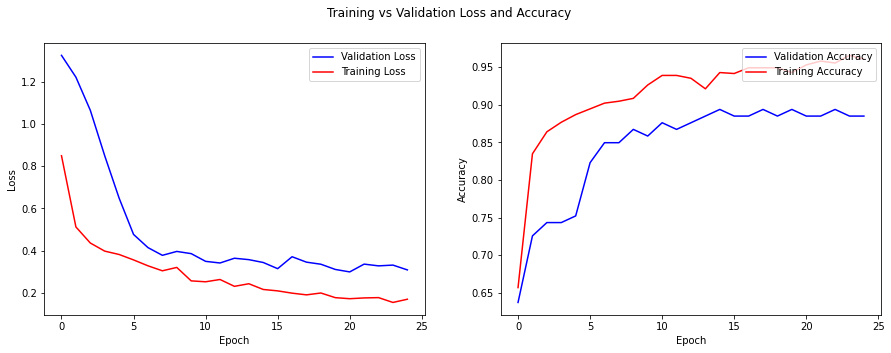

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(15, 5),squeeze=False)

ax[0][0].plot(epochs,val_epoch_loss_data,label='Validation Loss',color='blue')
ax[0][0].plot(epochs,train_epoch_loss_data,label='Training Loss',color='red')
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Loss')
ax[0][0].legend(loc="upper right")

ax[0][1].plot(epochs,val_epoch_acc_data,label='Validation Accuracy',color='blue')
ax[0][1].plot(epochs,train_epoch_acc_data,label='Training Accuracy',color='red')
ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].legend(loc="upper right")

fig.suptitle("Training vs Validation Loss and Accuracy")

plt.show()

Accuracy for label - Cloudy:	0.9385
Accuracy for label - Rain:	0.9375
Accuracy for label - Shine:	0.875
Accuracy for label - Sunrise:	0.9167

Mean Macro Precision: 0.9156 
Mean Macro Recall: 0.9156 
Mean Macro F1 Score: 0.9156
tensor([[61,  2,  2,  0],
        [ 1, 30,  1,  0],
        [ 5,  2, 49,  0],
        [ 3,  1,  2, 66]], dtype=torch.int32)


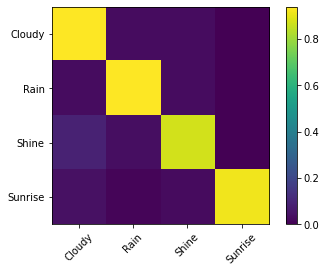

In [ ]:
# load best model
best_path = "best_cnn_sgd"
model = torch.load(best_path)
label_Space = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
# evaluate on test set
model = model.eval()

test_total_true = 0
test_total_predicted = 0
test_total_loss = 0
test_acc = 0
test_loss = 0
total_pred= 0
indv_acc = [0,0,0,0,0,0,0,0,0,0]  #labels_space.size()

con_matrix = torch.zeros(4, 4, dtype = torch.int)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is selected as the loss fonction


with torch.no_grad():
#   iterate over test batches
  for i, data in enumerate(test_loader, 0):
      labels, inputs = data

      labels = labels.cuda()
      inputs = inputs.cuda()

      outputs = model(inputs.float())
      pred = torch.argmax(outputs,1)
      
      total_pred += pred.shape[0]

      for i in range(pred.shape[0]):
        con_matrix[labels[i]][pred[i]] += 1
        if pred[i] == labels[i]:
          test_total_true += 1
      
  test_total_predicted = torch.sum(torch.diag(con_matrix)).item()
#   get confusion matrix
  for index,i in enumerate(con_matrix):
    indv_acc[index] = torch.diag(con_matrix)[index].item() / sum(i)
    answer = str(round(indv_acc[index].item(),4))
    print("Accuracy for label - " + label_Space[index] + ":\t" + answer)

  fn_cnn = torch.sum(torch.sum(con_matrix, dim = 0) - torch.diag(con_matrix)) #row by row
  fp_cnn = torch.sum(torch.sum(con_matrix, dim = 1) - torch.diag(con_matrix)) #column by colum

  precision_cnn = test_total_true / (test_total_true + fp_cnn.item())
  recall_cnn = test_total_true / (test_total_true + fn_cnn.item())
  f1_cnn = (2 * precision_cnn * recall_cnn) / (precision_cnn + recall_cnn)
#   calculate accuracy
  acc = round(test_total_predicted / 2000)
#   calculate precision
  pre = round(precision_cnn,4)
#   calculate recall
  recall = round(recall_cnn,4)
#   calculate F1 score
  f1 = round(f1_cnn,4)

# print metrics
  print("\nMean Macro Precision:", pre, "\nMean Macro Recall:", recall, "\nMean Macro F1 Score:", f1) 

# plot confusion matrix
  print(con_matrix)
  con_matrix = np.array(con_matrix)
  cm = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm, interpolation='nearest')
  plt.colorbar()
  tick_marks = np.arange(4)
  plt.xticks(tick_marks, label_Space, rotation=45)
  plt.yticks(tick_marks, label_Space)
  fig.tight_layout()
  plt.show()

In [ ]:

max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 9e-2
weight_decay = 5e-04

use_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# initialize your network
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
for para in model.parameters():
  para.requires_grad = False


fc = nn.Sequential( nn.Linear(512,4), nn.LogSoftmax(dim=1))

model.fc = fc
model = model.to(use_gpu)

# define your loss function
    
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 5e-04) # you can play with momentum and weight_decay parameters as well

criterion = nn.CrossEntropyLoss()
    

train_epoch_acc_data = []
train_epoch_loss_data = []
val_epoch_acc_data = []
val_epoch_loss_data = []
epochs = np.arange(max_epoch)
val_best_acc = 0

for epoch in range(max_epoch):
#    iterate over training batches

  model=model.train()
  train_total_loss = 0
  train_batch_count = 0
  train_total_true = 0
  train_total_predicted = 0
  train_running_loss = 0.0
  val_total_loss = 0
  val_batch_count = 0
  val_total_true = 0
  val_total_predicted = 0

  for i, (labels, inputs) in enumerate(train_loader):
    train_batch_count += 1

    labels = labels.cuda()
    inputs = inputs.cuda()
    # zero the parameter gradients
    optimizer.zero_grad()

    
    outputs = model(inputs.float())

    pred = torch.argmax(outputs,1)
    train_total_true += torch.sum(pred == labels).detach().cpu().numpy()
    train_total_predicted += labels.shape[0]

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  
  train_avg_loss = train_running_loss / train_batch_count
  train_avg_acc = train_total_true / train_total_predicted
  
  train_epoch_acc_data.append(train_avg_acc)
  train_epoch_loss_data.append(train_avg_loss)

#    Validation
  model = model.eval()
  with torch.no_grad():
#     iterate over validation batches
    for i, data in enumerate(val_loader, 0):
      val_batch_count += 1
      labels, inputs = data

      labels = labels.cuda()
      inputs = inputs.cuda()

      outputs = model(inputs.float())
      pred = torch.argmax(outputs,1)
      val_total_true += torch.sum(pred == labels).detach().cpu().numpy()
      val_total_predicted += labels.shape[0]
      val_total_loss += criterion(outputs, labels).item()
      

  val_acc = val_total_true / val_total_predicted
  val_loss = val_total_loss/val_batch_count

  val_epoch_acc_data.append(val_acc)
  val_epoch_loss_data.append(val_loss)

  print('Epoch: ' + str(epoch + 1) + "\t" + "Train Loss: " + str(round(train_avg_loss,4))
                  + "\tTrain Accuracy: " + str(round(train_avg_acc.item(),4))
                  + "\tVal Loss: " + str(round(val_loss,4))
                  + "\tVal Accuracy: " + str(round(val_acc.item(),4)))

  if val_acc >= val_best_acc:
    val_best_acc = val_acc
    best_learning_rate = learning_rate
    torch.save(model,"best_cnn_transfer")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1	Train Loss: 7.4431	Train Accuracy: 0.3088	Val Loss: 3.6996	Val Accuracy: 0.6814
Epoch: 2	Train Loss: 0.6498	Train Accuracy: 0.8691	Val Loss: 0.1859	Val Accuracy: 0.9204
Epoch: 3	Train Loss: 0.1575	Train Accuracy: 0.9454	Val Loss: 0.121	Val Accuracy: 0.9469
Epoch: 4	Train Loss: 0.1919	Train Accuracy: 0.9314	Val Loss: 0.1537	Val Accuracy: 0.9735
Epoch: 5	Train Loss: 0.1297	Train Accuracy: 0.9606	Val Loss: 0.2599	Val Accuracy: 0.9115
Epoch: 6	Train Loss: 0.1155	Train Accuracy: 0.953	Val Loss: 0.1199	Val Accuracy: 0.9381
Epoch: 7	Train Loss: 0.0958	Train Accuracy: 0.9733	Val Loss: 0.4036	Val Accuracy: 0.8584
Epoch: 8	Train Loss: 0.0899	Train Accuracy: 0.9695	Val Loss: 0.3003	Val Accuracy: 0.8938
Epoch: 9	Train Loss: 0.086	Train Accuracy: 0.9682	Val Loss: 0.5568	Val Accuracy: 0.7965
Epoch: 10	Train Loss: 0.1379	Train Accuracy: 0.9517	Val Loss: 0.1226	Val Accuracy: 0.9646


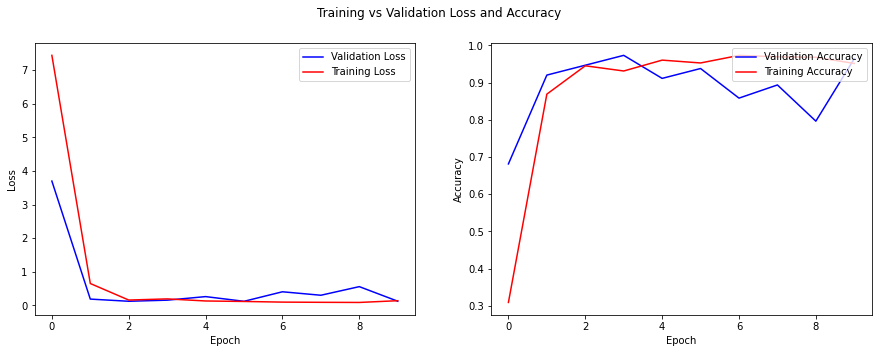

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(15, 5),squeeze=False)
ax[0][0].plot(epochs,val_epoch_loss_data,label='Validation Loss',color='blue')
ax[0][0].plot(epochs,train_epoch_loss_data,label='Training Loss',color='red')
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Loss')
ax[0][0].legend(loc="upper right")
ax[0][1].plot(epochs,val_epoch_acc_data,label='Validation Accuracy',color='blue')
ax[0][1].plot(epochs,train_epoch_acc_data,label='Training Accuracy',color='red')
ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].legend(loc="upper right")
fig.suptitle("Training vs Validation Loss and Accuracy")
plt.show()    

Accuracy for label - Cloudy:	0.9846
Accuracy for label - Rain:	0.9375
Accuracy for label - Shine:	0.8571
Accuracy for label - Sunrise:	0.9722
Mean Acc: 0.106 
Mean Macro Precision: 0.9422222222222222 
Mean Macro Recall: 0.9422222222222222 
Mean Macro F1 Score: 0.9422222222222222
tensor([[64,  0,  1,  0],
        [ 2, 30,  0,  0],
        [ 7,  1, 48,  0],
        [ 1,  0,  1, 70]], dtype=torch.int32)


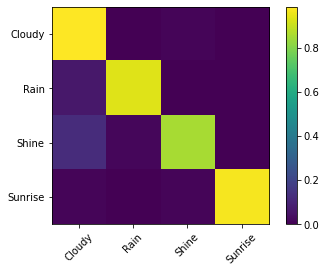

In [ ]:

best_path = "best_cnn_transfer"
model = torch.load(best_path)
label_Space = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
# evaluate on test set
model = model.eval()

test_total_true = 0
test_total_predicted = 0
test_total_loss = 0
test_acc = 0
test_loss = 0
total_pred= 0
indv_acc = [0,0,0,0,0,0,0,0,0,0]  #labels_space.size()

con_matrix = torch.zeros(4, 4, dtype = torch.int)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is selected as the loss fonction


with torch.no_grad():
#   iterate over test batches
  for i, data in enumerate(test_loader, 0):
      labels, inputs = data

      labels = labels.cuda()
      inputs = inputs.cuda()

      outputs = model(inputs.float())
      pred = torch.argmax(outputs,1)
      
      total_pred += pred.shape[0]

      # test_total_loss += criterion(outputs, labels).item()

      for i in range(pred.shape[0]):
        con_matrix[labels[i]][pred[i]] += 1
        if pred[i] == labels[i]:
          test_total_true += 1
      
  test_total_predicted = torch.sum(torch.diag(con_matrix)).item()
#   get confusion matrix
  for index,i in enumerate(con_matrix):
    indv_acc[index] = torch.diag(con_matrix)[index].item() / sum(i)
    answer = str(round(indv_acc[index].item(),4))
    print("Accuracy for label - " + label_Space[index] + ":\t" + answer)

  fn_cnn = torch.sum(torch.sum(con_matrix, dim = 0) - torch.diag(con_matrix)) #row by row
  fp_cnn = torch.sum(torch.sum(con_matrix, dim = 1) - torch.diag(con_matrix)) #column by colum

  precision_cnn = test_total_true / (test_total_true + fp_cnn.item())
  recall_cnn = test_total_true / (test_total_true + fn_cnn.item())
  f1_cnn = (2 * precision_cnn * recall_cnn) / (precision_cnn + recall_cnn)
#   calculate accuracy
  acc = (test_total_predicted / 2000)
#   calculate precision
  pre = (precision_cnn)
#   calculate recall
  recall = (recall_cnn)
#   calculate F1 score
  f1 = (f1_cnn)

# print metrics
  print("Mean Acc:", acc,"\nMean Macro Precision:", pre, "\nMean Macro Recall:", recall, "\nMean Macro F1 Score:", f1) 

# plot confusion matrix
  print(con_matrix)
  con_matrix = np.array(con_matrix)
  cm = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm, interpolation='nearest')
  plt.colorbar()
  tick_marks = np.arange(4)
  plt.xticks(tick_marks, label_Space, rotation=45)
  plt.yticks(tick_marks, label_Space)
  fig.tight_layout()
  plt.show()

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1